# Chapter 5 - Resampling

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')

from ISLP import load_data, confusion_table
from ISLP.models import (ModelSpec as MS, contrast, summarize)

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm


5. In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [146]:
data = load_data('Default')
data

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


(a) Fit a logistic regression model that uses income and balance to predict default.

In [147]:
model = MS(['income', 'balance'])
X = model.fit_transform(data)
y = data.default

In [148]:

logreg = LogisticRegression(C=1e10, solver='liblinear')
logreg.fit(X, y)

LogisticRegression(C=10000000000.0, solver='liblinear')

(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

- i. Split the sample set into a training set and a validation set.
- ii. Fit a multiple logistic regression model using only the training observations.
- iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.
- iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > .5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

print(f'Validation set error: {np.mean(logit_labels!=y_test)}')

Validation set error: 0.03363636363636364


(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [150]:
for i in range(1, 4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    logit = LogisticRegression(C=1e10, solver='liblinear')
    logit.fit(X_train, y_train)
    logit_pred = logit.predict_proba(X_test)
    logit_labels = np.where(logit_pred[:,1] > .5, 'Yes', 'No')
    confusion_table(logit_labels, y_test)
    
    print(f'Validation set error: {np.mean(logit_labels!=y_test)}')

Validation set error: 0.030303030303030304
Validation set error: 0.02666666666666667
Validation set error: 0.034545454545454546


In [151]:
The test error is around 3%. It seems quite estable from one training to another.

SyntaxError: invalid syntax (2217669644.py, line 1)

(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [152]:
data['student']=np.where(data.student == 'Yes', 1, 0)
model = MS(['income', 'balance', 'student'])
X = model.fit_transform(data)
y = data.default

for i in range(1, 4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    logit = LogisticRegression(C=1e10, solver='liblinear')
    logit.fit(X_train, y_train)
    logit_pred = logit.predict_proba(X_test)
    logit_labels = np.where(logit_pred[:,1] > .5, 'Yes', 'No')
    confusion_table(logit_labels, y_test)
    
    print(f'Validation set error: {np.mean(logit_labels!=y_test)}')

Validation set error: 0.030303030303030304
Validation set error: 0.026363636363636363
Validation set error: 0.034545454545454546


In [153]:
logit.coef_

array([[-2.04248768e-06, -1.24834766e-04,  3.66918121e-04,
        -2.67469980e-06]])

The predictor 'student' doesnt seem to have any impact on the model. Its coefficient is 0.

---

6. We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the sm.GLM() function. Do not forget to set a random seed before beginning your analysis.

(a) Using the summarize() and sm.GLM() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [154]:
np.random.seed(0)

X = data[['income', 'balance']]
y = data.default == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
income,-0.0032,7.824,-0.0,1.0
balance,-0.0634,286.106,-0.0,1.0


(b) Write a function, boot_fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [155]:
def boot_fn(D, idx):
    data = D.loc[idx]
    X = data[['income', 'balance']]
    y = data.default == 'Up'
    glm = sm.GLM(y,
                 X,
                 family=sm.families.Binomial())
    results = glm.fit()
    return summarize(results)['coef']

(c) Following the bootstrap example in the lab, use your boot_fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [156]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

boot_SE(boot_fn, data)

income     0.000729
balance    0.019981
Name: coef, dtype: float64

(d) Comment on the estimated standard errors obtained using the sm.GLM() function and using the bootstrap.

---

7. In Sections 5.1.2 and 5.1.3, we saw that the cross_validate() function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just sm.GLM() and the predict() method of the fitted model within a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classification problems, the LOOCV error is given in (5.4).

(a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2.

In [157]:
data = load_data('Weekly')
data

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [158]:
X = data[['Lag1', 'Lag2']]
y = data.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
Lag1,-0.0322,0.026,-1.235,0.217
Lag2,0.0664,0.026,2.511,0.012


(b) Fit a logistic regression model that predicts Direction using Lag1 and Lag2 using all but the first observation.

In [159]:

X = data[['Lag1', 'Lag2']]
y = data.Direction == 'Up'
glm = sm.GLM(y.iloc[1:],
             X.iloc[1:],
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
Lag1,-0.0318,0.026,-1.223,0.221
Lag2,0.0670,0.026,2.531,0.011


(c) Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if P (Direction = "Up"|Lag1, Lag2) > 0.5. Was this observation correctly classified?

In [160]:
print('Up' if results.predict(X.iloc[1])[0] > 0.5 else 'Down')

Up


(d) Write a for loop from i=1 to i=n, where n is the number of observations in the data set, that performs each of the following steps:
- i. Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2.
- ii. Compute the posterior probability of the market moving up for the ith observation.
- iii. Use the posterior probability for the ith observation in order to predict whether or not the market moves up.
- iv. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.

In [161]:
X = data[['Lag1', 'Lag2']]
y = data.Direction == 'Up'

predictions = []

for i in range(data.shape[0]):
    glm = sm.GLM(y.drop(y.index[i]),
                 X.drop(X.index[i]),
                 family=sm.families.Binomial())
    results = glm.fit()
    predictions.append(results.predict(X.iloc[i])[0]>0.5)


In [162]:
errors=predictions!=y

(e) Take the average of the n numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.

In [163]:
errors.mean()

0.46464646464646464

---

8. We will now perform cross-validation on a simulated data set.

(a) Generate a simulated data set as follows:

    rng = np.random.default_rng(1)
    x = rng.normal(size=100)
    y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model used to generate the data in equation form.

In [164]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

<Axes: >

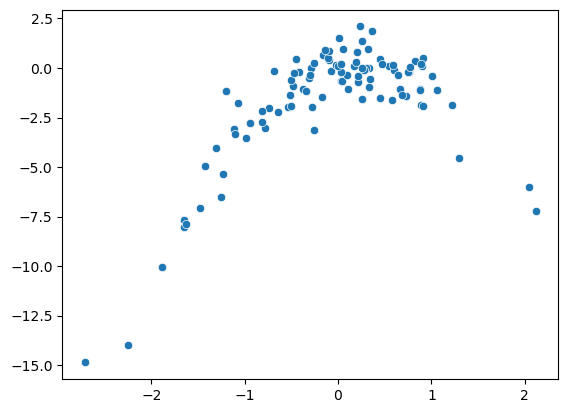

In [165]:
sns.scatterplot(x = x, y = y)

(b) Create a scatterplot of X against Y . Comment on what you find.

(c) Set a random seed, and then compute the LOOCV errors that
result from fitting the following four models using least squares:
- i. Y = β0 + β1X + ε
- ii. Y =β0 +β1X+β2X^2 +ε
- iii. Y =β0 +β1X+β2X^2 +β3X^3 +ε
- iv. Y =β0 +β1X+β2X^2 +β3X^3 +β4X^4 +ε.

Note you may find it helpful to use the data.frame() function to create a single data set containing both X and Y .

In [166]:
data = pd.DataFrame({
    'x': x,
    'y':y
})

data

,x,y
0,0.345584,-0.544554
1,0.821618,0.333950
2,0.330437,-0.013532
3,-1.303157,-4.030442
4,0.905356,0.484861
...,...,...
95,-2.250854,-14.001012
96,-0.138655,0.932532
97,0.033000,0.198928
98,-1.425349,-4.940183


In [167]:
np.random.seed(3)

cv_error = np.zeros(4)
M = sklearn_sm(sm.OLS)
for i in range(1,5):
    X = MS([poly('x', degree=i)]).fit_transform(data)
    M_CV = cross_validate(M,
                          X,
                          y,
                          cv=data.shape[0])
    cv_error[i-1] = np.mean(M_CV['test_score'])


Changing the seed doesnt affect the result since the LOOCV technique will perform the same operations after all independently of its 

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

The best model is the one introducing the quadratic term. The bias in the less complex model is too high and then, the models with more complexity seem to overfit the training data.

(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

---

9. We will now consider the Boston housing data set, from the ISLP library.

In [139]:
data = load_data('Boston')
data

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate μˆ.

In [143]:
mu = data['medv'].mean()
mu

22.532806324110677

(b) Provide an estimate of the standard error of μˆ. Interpret this result.

Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

(c) Now estimate the standard error of μˆ using the bootstrap. How does this compare to your answer from (b)?

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence interval for the mean of medv. Compare it to the results obtained by using Boston['medv'].std() and the two standard error rule (3.9).

Hint: You can approximate a 95 % confidence interval using the formula [μˆ − 2SE(μˆ), μˆ + 2SE(μˆ)].

(e) Based on this data set, provide an estimate, μˆmed, for the median value of medv in the population.

(f) We now would like to estimate the standard error of μˆmed. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

(g) Based on this data set, provide an estimate for the tenth percentile of medv in Boston census tracts. Call this quantity μˆ0.1. (You can use the np.percentile() function.) np.

(h) Use the bootstrap to estimate the standard error of μˆ0.1. Comment on your findings.